## Ashfaque Azad (MSc Computer Science [Data Analytics])

@article{rauber2017foolbox,
  
  title={Foolbox: A Python toolbox to benchmark the robustness of machine learning models},
  
  author={Rauber, Jonas and Brendel, Wieland and Bethge, Matthias},
  
  journal={arXiv preprint arXiv:1707.04131},
  
  year={2017},
  
  url={http://arxiv.org/abs/1707.04131 , https://github.com/bethgelab/foolbox},
  
  archivePrefix={arXiv},
  
  eprint={1707.04131},
}

In [0]:
!pip install image
!pip install foolbox
!pip install torch
!pip install torchvision

In [3]:
from google.colab import files
uploaded=files.upload()

Saving tiger.jpeg to tiger.jpeg


In [0]:
# This block contains code from https://github.com/bethgelab/foolbox
import os

import numpy as np


def imagenet_example(shape=(224, 224)):
    """ Returns an example image and its imagenet class label.
    Parameters
    ----------
    shape : list of integers
        The shape of the returned image.
    Returns
    -------
    image : array_like
        The example image.
    label : int
        The imagenet label associated with the image.
    """
    from PIL import Image
#     path = os.path.join(os.path.dirname(__file__), 'example.png')
    path = os.path.join('tiger.jpeg')
    image = Image.open(path)
    image = image.resize(shape)
    image = np.asarray(image, dtype=np.float32)
    image = image[:, :, :3]
    assert image.shape == shape + (3,)
    return image

In [0]:
import foolbox
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50

from foolbox.criteria import TargetClassProbability
target_class = 404 #https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b
criterion = TargetClassProbability(target_class, p=0.85)

# instantiate model
keras.backend.set_learning_phase(0)

kmodel = ResNet50(weights='imagenet')#The keras model that should be attacked

# we first subtract the first element of preprocessing from the input and then divide the input by
#the second element. This is done in the fmodel
preprocessing = (np.array([104, 116, 123]), 1)

#bounds : tuple.Tuple of lower and upper bound for the pixel values.
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

# get source image and label
image = imagenet_example()

#Uses L-BFGS-B to minimize the distance between the image and the adversarial 
#as well as the cross-entropy between the predictions for the adversarial and the the one-hot encoded target class.
#If the criterion does not have a target class, a random class is chosen 
#from the set of all classes except the original one. (foolbox)
attack = foolbox.attacks.LBFGSAttack(fmodel,criterion)

# apply attack on source image
# ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
adversarial = attack(image[:, :, ::-1], 404)#404 the target label
#https://www.pexels.com/search/tiger/

In [0]:
imageX=image

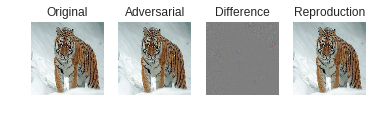

In [5]:
# if you use Jupyter notebooks
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure()

plt.subplot(1, 4, 1)
plt.title('Original')
plt.imshow(imageX / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - imageX
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Reproduction')
reproduction=adversarial[:, :, ::-1]-difference
plt.imshow(reproduction/255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.show()

In [0]:
reproductionX=reproduction

In [7]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions


# show results
print("Class No. of the original Image:",np.argmax(fmodel.predictions(imageX)))
NewimageX=imageX[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(NewimageX.copy()))
print("Top 3 predictions (ORIGINAL: ", decode_predictions(preds, top=3))

print("Class No. of the Reproduced Image:",np.argmax(fmodel.predictions(reproductionX)))
NewreproductionX=reproductionX[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(NewreproductionX.copy()))
print("Top 3 predictions (REPRODUCED: ", decode_predictions(preds, top=3))

print("Class No. of the Adversarial Image:",np.argmax(fmodel.predictions(adversarial)))
adversarial_rgb = adversarial[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 3 predictions (ADVERSARIAL: ", decode_predictions(preds, top=3))

Class No. of the original Image: 292
40960/35363 [==================================] - 0s 1us/step
Top 3 predictions (ORIGINAL:  [[('n02129604', 'tiger', 0.6894254), ('n02123159', 'tiger_cat', 0.23512329), ('n02127052', 'lynx', 0.059191305)]]
Class No. of the Reproduced Image: 292
Top 3 predictions (REPRODUCED:  [[('n02129604', 'tiger', 0.6894254), ('n02123159', 'tiger_cat', 0.23512329), ('n02127052', 'lynx', 0.059191305)]]
Class No. of the Adversarial Image: 404
Top 3 predictions (ADVERSARIAL:  [[('n02690373', 'airliner', 0.9252312), ('n02129604', 'tiger', 0.025506137), ('n02123159', 'tiger_cat', 0.011117672)]]


## Flipping the adversarial image makes it lose its robustness

However we see that flipping the images (in our case horizontally) made not only the adversarial image lose its robustness but also resulted in the original image being classified correctly but with lower confidence 

In [9]:
import numpy
print("Class No. of the original Image:",np.argmax(fmodel.predictions(numpy.fliplr(image))))
NewimageZ = numpy.fliplr(image)[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(NewimageZ.copy()))
print("Top 3 predictions (ORIGINAL: ", decode_predictions(preds, top=3))

print("Class No. of the Adversarial Image:",np.argmax(fmodel.predictions(numpy.fliplr(adversarial))))
adversarial_rgb = numpy.fliplr(adversarial)[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 3 predictions (ADVERSARIAL: ", decode_predictions(preds, top=3))#adversarial example is not rotation-invariant!

Class No. of the original Image: 292
Top 3 predictions (ORIGINAL:  [[('n02129604', 'tiger', 0.40612164), ('n02123159', 'tiger_cat', 0.3805719), ('n02127052', 'lynx', 0.16065846)]]
Class No. of the Adversarial Image: 292
Top 3 predictions (ADVERSARIAL:  [[('n02129604', 'tiger', 0.93176186), ('n02123159', 'tiger_cat', 0.06578519), ('n02127052', 'lynx', 0.0021654083)]]


## Flipping the adversarial image

(-0.5, 223.5, 223.5, -0.5)

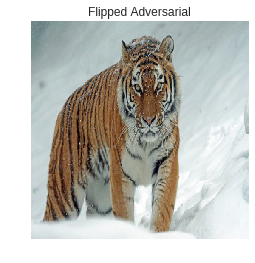

In [10]:
plt.figure()
plt.title('Flipped Adversarial')
rotAdversarial=numpy.fliplr(adversarial)[:, :, ::-1]
plt.imshow(rotAdversarial/255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

## Median Blur

Median filter (3 x 3 filter window size) also makes the adversarial lose its robustness i.e. it no longer fools the model. Also, median filter does not degrade the model's confidence on the original image (unperturbed) by a huge amount.

In [0]:
import cv2
median = cv2.medianBlur(adversarial,3)
medianImage = cv2.medianBlur(image,3)
#https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=medianblur#medianblur

In [14]:
print("Class No. of the Adversarial Image:",np.argmax(fmodel.predictions(medianImage)))
adversarial_rgb = medianImage[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 3 predictions (IMAGE: ", decode_predictions(preds, top=3))#

print("Class No. of the Adversarial Image:",np.argmax(fmodel.predictions(median)))
adversarial_rgb = median[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 3 predictions (ADVERSARIAL: ", decode_predictions(preds, top=3))#

Class No. of the Adversarial Image: 292
Top 3 predictions (IMAGE:  [[('n02129604', 'tiger', 0.63721675), ('n02123159', 'tiger_cat', 0.10871302), ('n02128757', 'snow_leopard', 0.039593223)]]
Class No. of the Adversarial Image: 292
Top 3 predictions (ADVERSARIAL:  [[('n02129604', 'tiger', 0.885688), ('n02123159', 'tiger_cat', 0.09100002), ('n02127052', 'lynx', 0.011798608)]]


## Median Filter on Adversarial Images

(-0.5, 223.5, 223.5, -0.5)

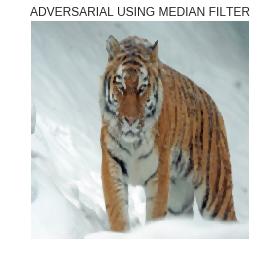

In [15]:
plt.figure()
plt.title('ADVERSARIAL USING MEDIAN FILTER')
reproduction=median[:, :, ::-1]
plt.imshow(reproduction/255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

## Using both flipping and median filtering together
**Flipping the image and then using median filter**

In [0]:
import cv2
medianImage = cv2.medianBlur(numpy.fliplr(image),3)
medianAdv = cv2.medianBlur(numpy.fliplr(adversarial),3)

In [12]:
print("Class No. of the Adversarial Image:",np.argmax(fmodel.predictions(medianImage)))
adversarial_rgb = medianImage[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 3 predictions (ORIGINAL: ", decode_predictions(preds, top=3))#

print("Class No. of the Adversarial Image:",np.argmax(fmodel.predictions(medianAdv)))
adversarial_rgb = medianAdv[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 3 predictions (ADVERSARIAL: ", decode_predictions(preds, top=3))#

Class No. of the Adversarial Image: 292
Top 3 predictions (ORIGINAL:  [[('n02129604', 'tiger', 0.40306672), ('n02123159', 'tiger_cat', 0.14402232), ('n02127052', 'lynx', 0.07077334)]]
Class No. of the Adversarial Image: 292
Top 3 predictions (ADVERSARIAL:  [[('n02129604', 'tiger', 0.9110268), ('n02123159', 'tiger_cat', 0.07734251), ('n02127052', 'lynx', 0.005049255)]]


## Using both flipping and median filtering together
**Using median filter on the image and then flipping it horizontally **

This just shows that median filter and flip are independent operations

In [0]:
medianImage = numpy.fliplr(cv2.medianBlur(image,3))
medianAdv = numpy.fliplr(cv2.medianBlur(adversarial,3))

In [17]:
print("Class No. of the Adversarial Image:",np.argmax(fmodel.predictions(medianImage)))
adversarial_rgb = medianImage[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 3 predictions (ORIGINAL: ", decode_predictions(preds, top=3))#

print("Class No. of the Adversarial Image:",np.argmax(fmodel.predictions(medianAdv)))
adversarial_rgb = medianAdv[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 3 predictions (ADVERSARIAL: ", decode_predictions(preds, top=3))#

Class No. of the Adversarial Image: 292
Top 3 predictions (ORIGINAL:  [[('n02129604', 'tiger', 0.40306672), ('n02123159', 'tiger_cat', 0.14402232), ('n02127052', 'lynx', 0.07077334)]]
Class No. of the Adversarial Image: 292
Top 3 predictions (ADVERSARIAL:  [[('n02129604', 'tiger', 0.9110268), ('n02123159', 'tiger_cat', 0.07734251), ('n02127052', 'lynx', 0.005049255)]]
